# **Signal Processing in Practice**

Assignment 9

Name: Saptarshi Mandal

SR. No.: 22925

Course: MTech Signal Processing

Department: Electrical Engineering

In [1]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import skimage
from skimage.io import imread
import cv2

In [12]:
# Loading Images

lena = cv2.cvtColor(imread('lena.png'),cv2.COLOR_BGR2GRAY)
study = imread('study.png')
butterfly = cv2.cvtColor(imread('butterfly.jpeg'),cv2.COLOR_BGR2GRAY)
doremon = cv2.cvtColor(imread('doremon.jpg'),cv2.COLOR_BGR2GRAY)
kashmir = cv2.cvtColor(imread('kashmir.webp'),cv2.COLOR_BGR2GRAY)

### **Inverse Distance Weighted Image Interpolation**

$w_{j,i} = \frac{1}{1 + \alpha \left\| y_i - z_j \right\|_2^p}$


In [72]:
def generate_corrupted_image(image, fraction = 0.3, window_size = 21):

    corruption_mask = np.random.rand(image.shape[0]-window_size+1,image.shape[1]-window_size+1) > fraction

    corruption_mask = np.pad(corruption_mask,(window_size//2,window_size//2), constant_values=(1, 1))

    return image.copy() * corruption_mask, corruption_mask


def plot_corrupted_images(original_image, corrupted_image):

    # Plotting
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(corrupted_image, cmap='gray')
    plt.title('Corrupted Image')
    plt.axis('off')

    plt.show()


def plot_restored_images(original_image, corrupted_image, restored_image, alpha, p):

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(corrupted_image, cmap='gray')
    plt.title(f'Corrupted Image \nMSE: {mse(original_image,corrupted_image):.4f}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(restored_image, cmap='gray')
    plt.title(f'Restored Image\n Alpha: {alpha}, p: {p}, MSE: {mse(original_image,restored_image):.4f}')
    plt.axis('off')

    plt.show()


In [57]:
def mse(img1, img2):
    return np.mean((img1.astype('float') - img2.astype('float'))**2)

In [58]:
def restore_image(img, corruption_mask, window_size = 21, alpha = 1, p = 2):

    reconstructed_image = img.copy()

    # weights
    x = np.arange(-(window_size//2),window_size//2)
    y = np.arange(-(window_size//2),window_size//2)

    yv, xv = np.meshgrid(x, y)
    w = 1 / (1 + alpha * (xv**2 + yv**2)**(p/2))

    dead_pixels = np.dstack((np.where(corruption_mask==0)[0],np.where(corruption_mask==0)[1]))[0]

    for pixel_location in dead_pixels:

        patch = img[pixel_location[0] - window_size//2 :pixel_location[0] + window_size//2, pixel_location[1] - window_size//2 :pixel_location[1] + window_size//2]

        norm_w = w[patch!=0]
        normalization = np.sum(norm_w)
        reconstructed_image[pixel_location[0]][pixel_location[1]] = np.sum(w * patch) / normalization

    return reconstructed_image

In [61]:
corrupted_lena, corruption_mask_lena = generate_corrupted_image(lena, fraction = 0.3, window_size = 25)
corrupted_study, corruption_mask_study = generate_corrupted_image(study, fraction = 0.3, window_size = 25)
corrupted_butterfly, corruption_mask_butterfly = generate_corrupted_image(butterfly, fraction = 0.3, window_size = 25)
corrupted_doremon, corruption_mask_doremon = generate_corrupted_image(doremon, fraction = 0.3, window_size = 25)
corrupted_kashmir, corruption_mask_kashmir = generate_corrupted_image(kashmir, fraction = 0.3, window_size = 25)

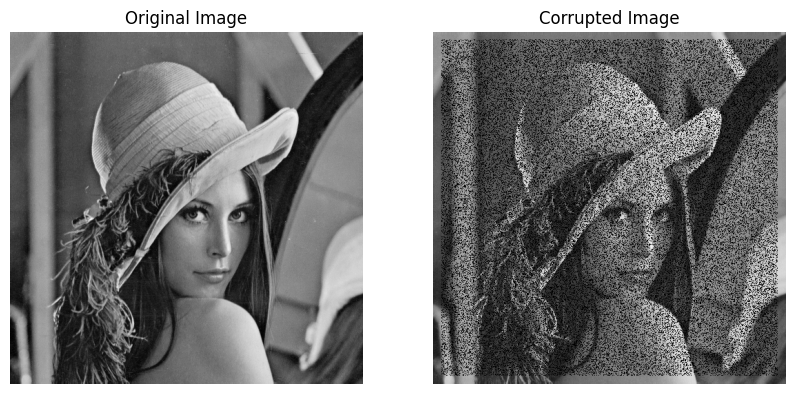

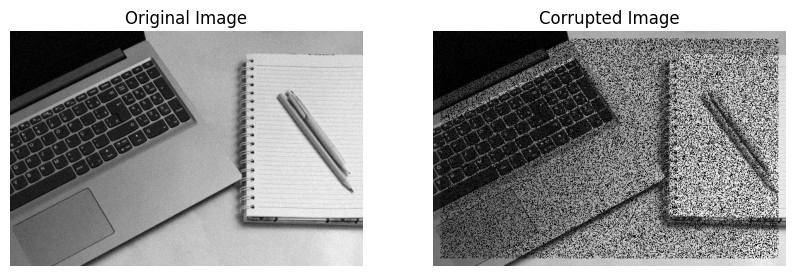

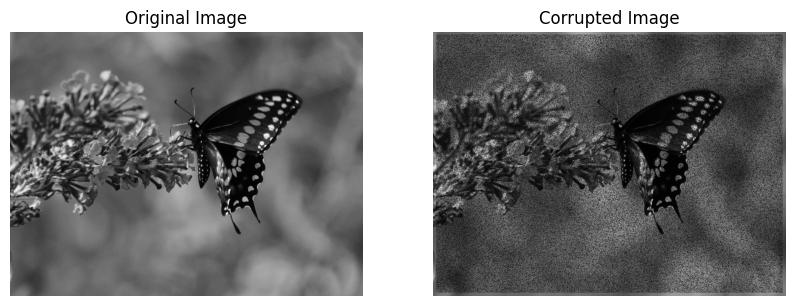

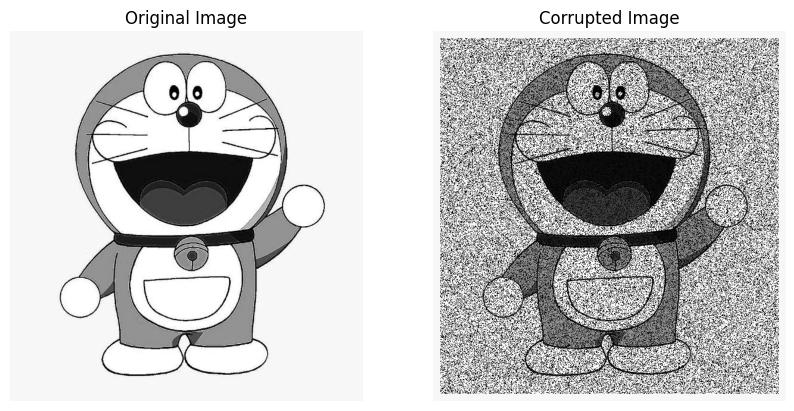

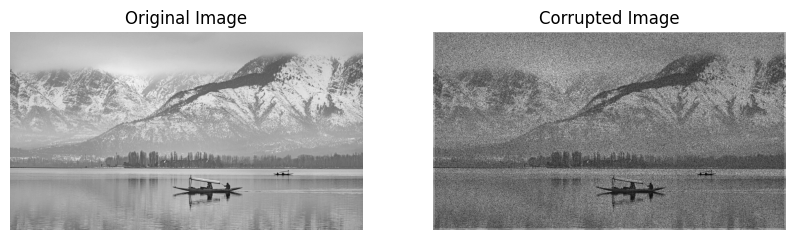

In [73]:
# Visulization Cell

plot_corrupted_images(lena, corrupted_lena)
plot_corrupted_images(study, corrupted_study)
plot_corrupted_images(butterfly, corrupted_butterfly)
plot_corrupted_images(doremon, corrupted_doremon)
plot_corrupted_images(kashmir, corrupted_kashmir)

### **Finding Optimal $\alpha$**

In [32]:
# Finding Optimal Parameters

def find_optimal_alpha(original_image, fraction):

    optimal_window_size = 25

    alphas = [0.1, 0.5, 1.0, 1.5, 2.0]

    MSE_array = np.zeros(len(alphas))

    for j, alpha in enumerate(alphas):
        corrupted_img, corruption_mask = generate_corrupted_image(original_image, fraction=fraction, window_size=optimal_window_size)
        restored_img = restore_image(img=corrupted_img, corruption_mask=corruption_mask, window_size=optimal_window_size, alpha=alpha, p = 2)
        MSE_array[j] = mse(original_image, restored_img)

    # Plotting MSE against alphas
    plt.plot(alphas, MSE_array, marker='o')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs. Alpha')
    plt.grid(True)
    plt.show()

    # Finding optimal alpha
    optimal_alpha = alphas[np.argmin(MSE_array)]

    print("Optimal Alpha:", optimal_alpha)
    print("Minimum MSE:", np.min(MSE_array))

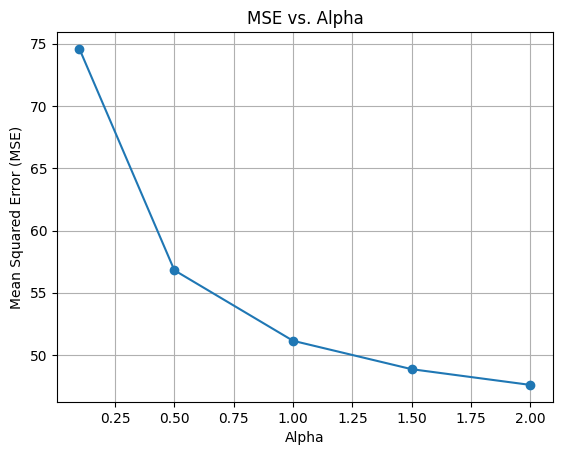

Optimal Alpha: 2.0
Minimum MSE: 47.596031188964844


In [34]:
# Lena

find_optimal_alpha(lena, fraction = 0.3)

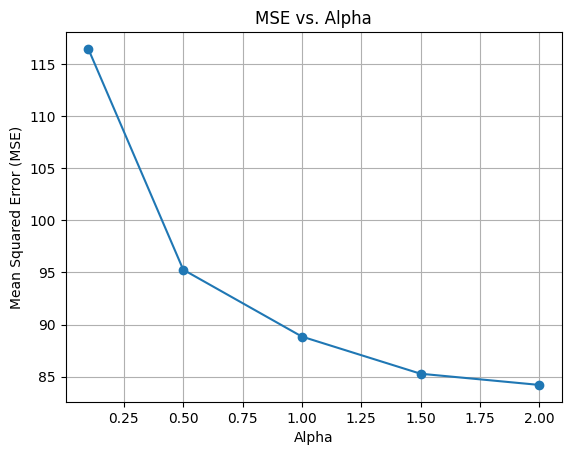

Optimal Alpha: 2.0
Minimum MSE: 84.20278628877824


In [35]:
# Study

find_optimal_alpha(study, fraction = 0.3)

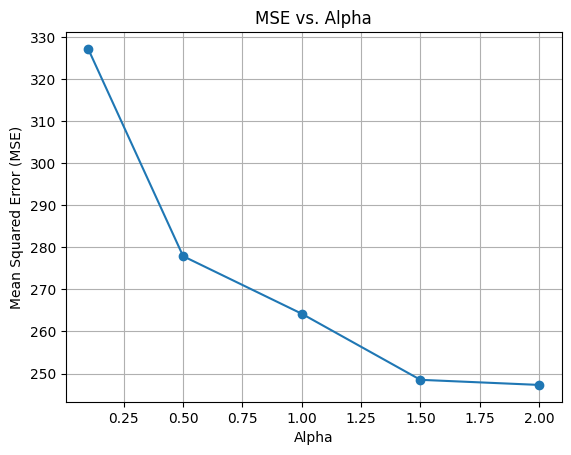

Optimal Alpha: 2.0
Minimum MSE: 247.2976716570059


In [36]:
# Doremon

find_optimal_alpha(doremon, fraction = 0.3)

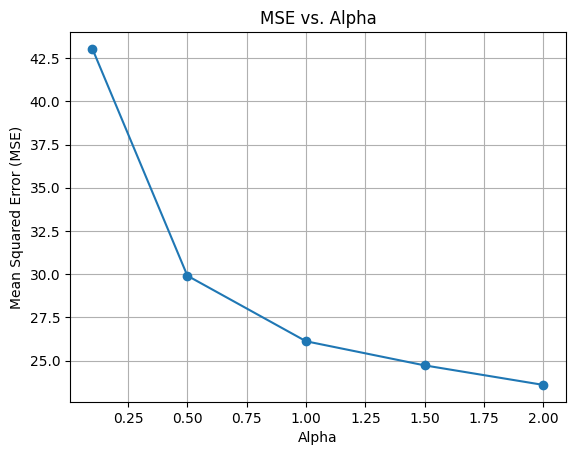

Optimal Alpha: 2.0
Minimum MSE: 23.593219140218523


In [37]:
# Butterfly

find_optimal_alpha(butterfly, fraction = 0.3)

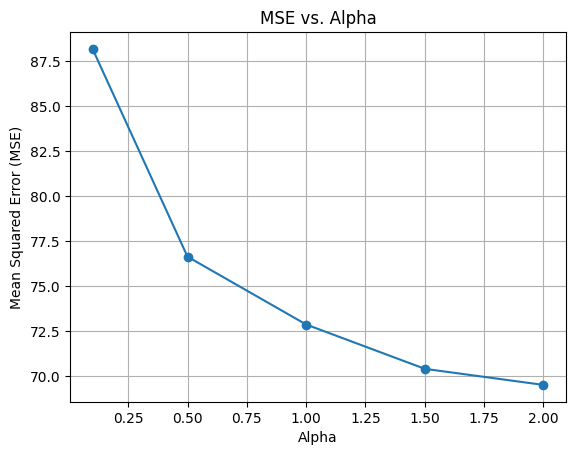

Optimal Alpha: 2.0
Minimum MSE: 69.52191134982638


In [38]:
# Kashmir

find_optimal_alpha(kashmir, fraction = 0.3)

### **Finding Optimal p**

In [43]:
def find_optimal_p(original_image, fraction, optimal_alpha):

    optimal_window_size = 25

    ps = [1, 2, 3, 4]

    MSE_array = np.zeros(len(ps))

    for j, p in enumerate(ps):
        corrupted_img, corruption_mask = generate_corrupted_image(original_image, fraction=fraction, window_size=optimal_window_size)
        restored_img = restore_image(img=corrupted_img, corruption_mask=corruption_mask, window_size=optimal_window_size, alpha=optimal_alpha, p=p)
        MSE_array[j] = mse(original_image, restored_img)

    # Plotting MSE against ps
    plt.plot(ps, MSE_array, marker='o')
    plt.xlabel('p')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs. p')
    plt.grid(True)
    plt.show()

    # Finding optimal p
    optimal_p = ps[np.argmin(MSE_array)]

    print("Optimal p:", optimal_p)
    print("Minimum MSE:", np.min(MSE_array))


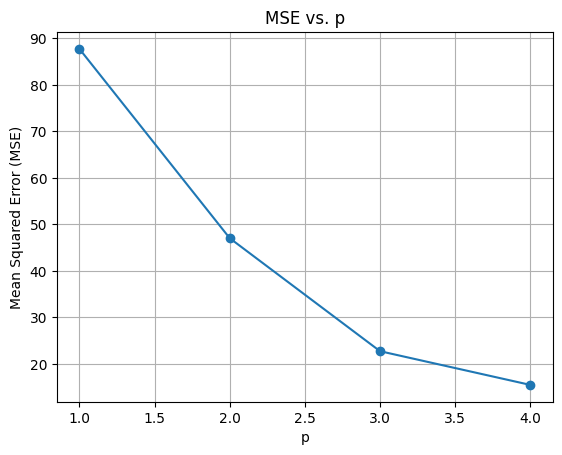

Optimal p: 4
Minimum MSE: 15.467487335205078


In [44]:
# Lena

find_optimal_p(lena, fraction = 0.3, optimal_alpha = 2)

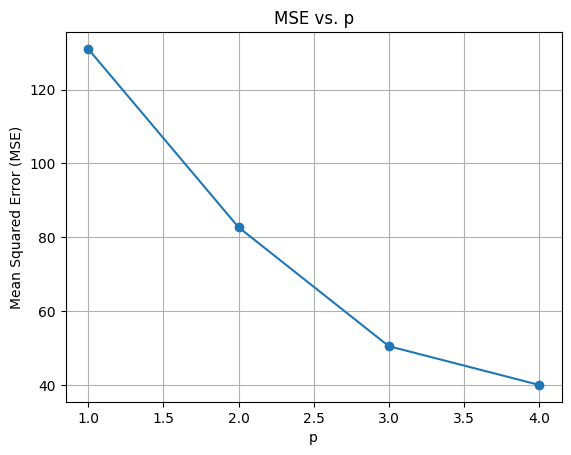

Optimal p: 4
Minimum MSE: 40.01238031405592


In [45]:
# study

find_optimal_p(study, fraction = 0.3, optimal_alpha = 2)

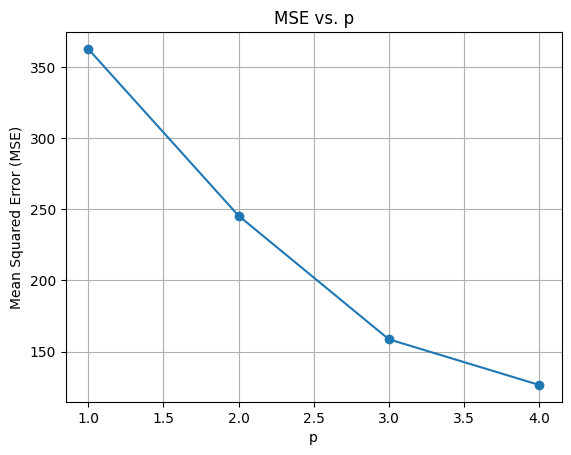

Optimal p: 4
Minimum MSE: 126.64394896515077


In [46]:
# Doremon

find_optimal_p(doremon, fraction = 0.3, optimal_alpha = 2)

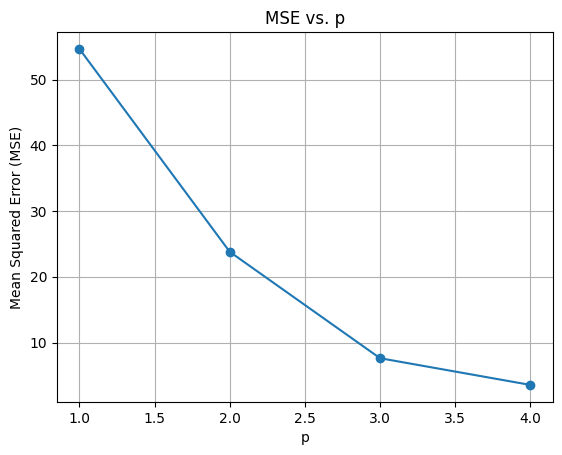

Optimal p: 4
Minimum MSE: 3.5462156932882416


In [47]:
# Butterfly

find_optimal_p(butterfly, fraction = 0.3, optimal_alpha = 2)

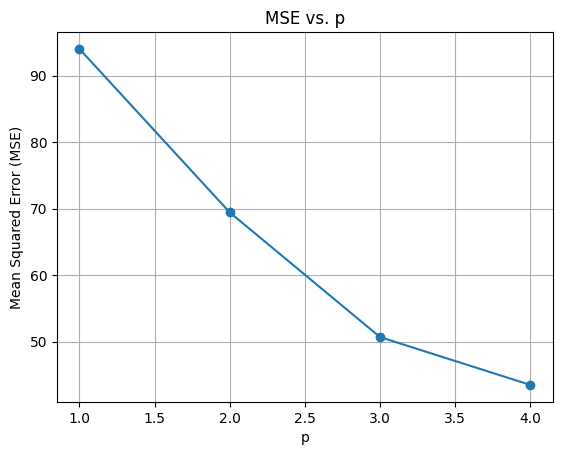

Optimal p: 4
Minimum MSE: 43.48822075737847


In [48]:
# Kashmir

find_optimal_p(kashmir, fraction = 0.3, optimal_alpha = 2)

### **Best Restored Images**

In [59]:
restored_lena = restore_image(img = corrupted_lena, corruption_mask = corruption_mask_lena, window_size = 25, alpha = 2, p = 4)
restored_study = restore_image(img = corrupted_study, corruption_mask = corruption_mask_study, window_size = 25, alpha = 2, p = 4)
restored_butterfly = restore_image(img = corrupted_butterfly, corruption_mask = corruption_mask_butterfly, window_size = 25, alpha = 2, p = 4)
restored_doremon = restore_image(img = corrupted_doremon, corruption_mask = corruption_mask_doremon, window_size = 25, alpha = 2, p = 4)
restored_kashmir = restore_image(img = corrupted_kashmir, corruption_mask = corruption_mask_kashmir, window_size = 25, alpha = 2, p = 4)

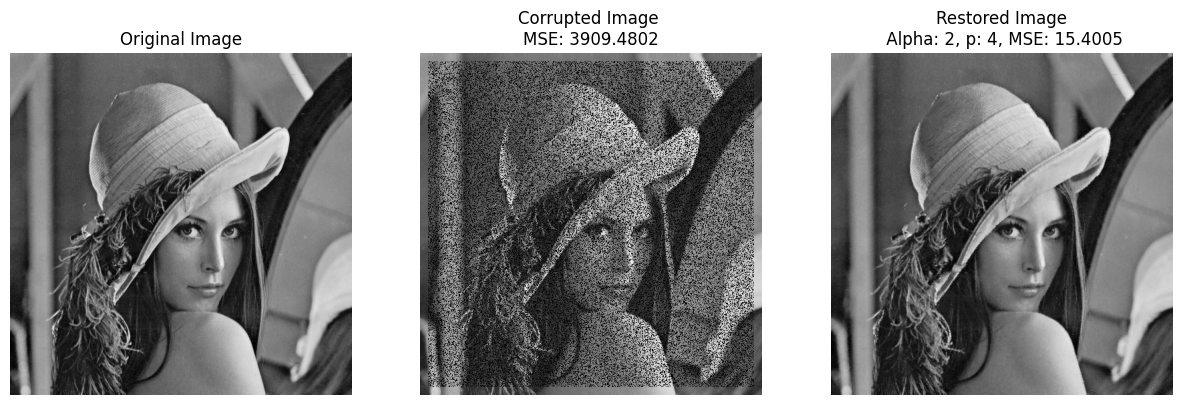

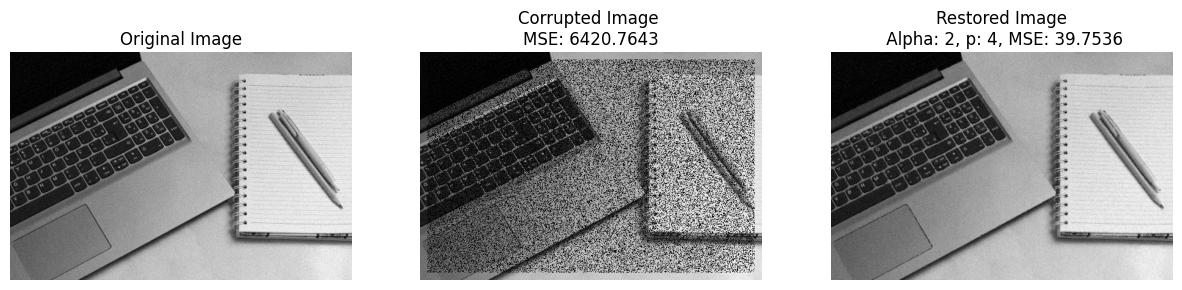

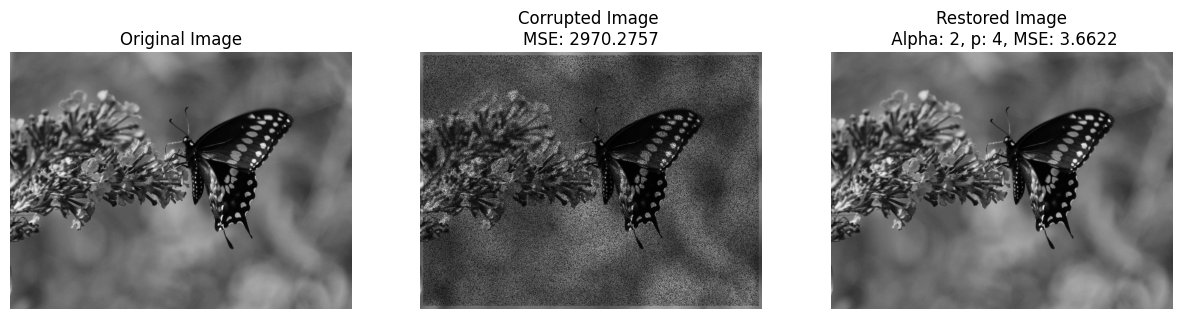

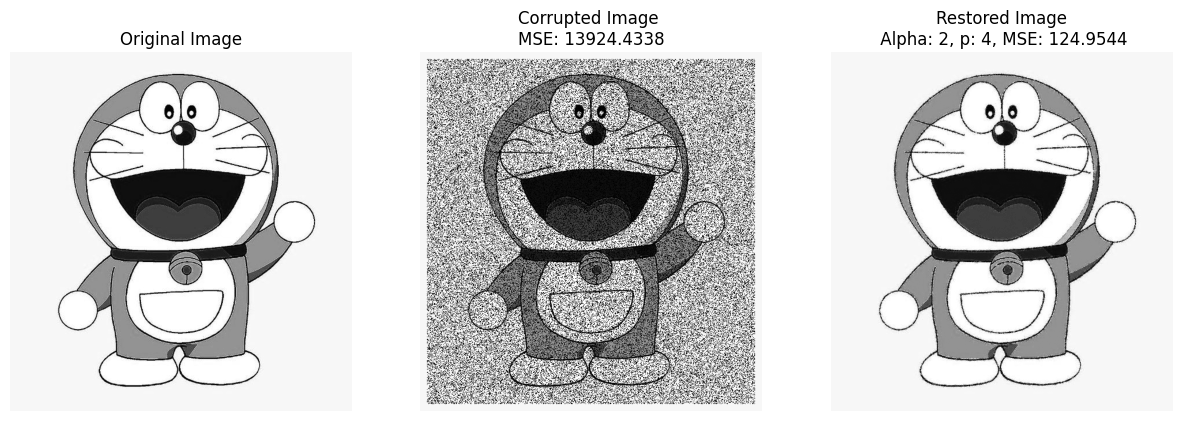

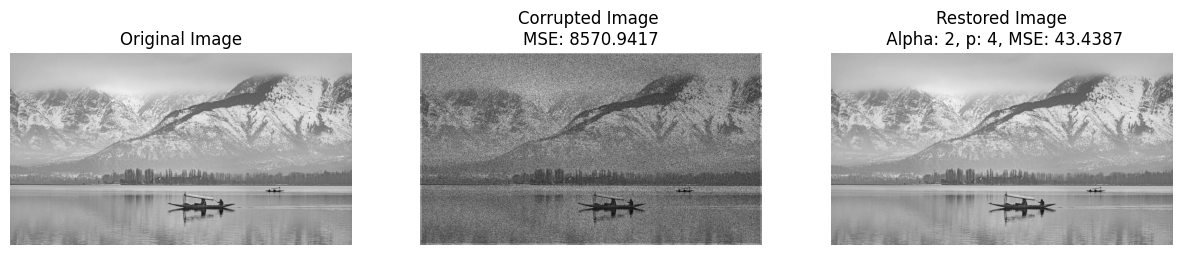

In [69]:
plot_restored_images(lena, corrupted_lena, restored_lena, alpha = 2, p = 4)
plot_restored_images(study, corrupted_study, restored_study, alpha = 2, p = 4)
plot_restored_images(butterfly, corrupted_butterfly, restored_butterfly, alpha = 2, p = 4)
plot_restored_images(doremon, corrupted_doremon, restored_doremon, alpha = 2, p = 4)
plot_restored_images(kashmir, corrupted_kashmir, restored_kashmir, alpha = 2, p = 4)